In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import statsmodels.api as sm 

# 결측치 탐지
import missingno as msno

In [2]:
df = pd.read_csv("./data/sonar.csv", header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [4]:
df.shape

(208, 61)

In [5]:
# 옛날에는 진짜 대규모 프로젝트라 겁나 오래걸렸다

In [6]:
df.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
56    float64
57    float64
58    float64
59    float64
60     object
Length: 61, dtype: object

<Axes: >

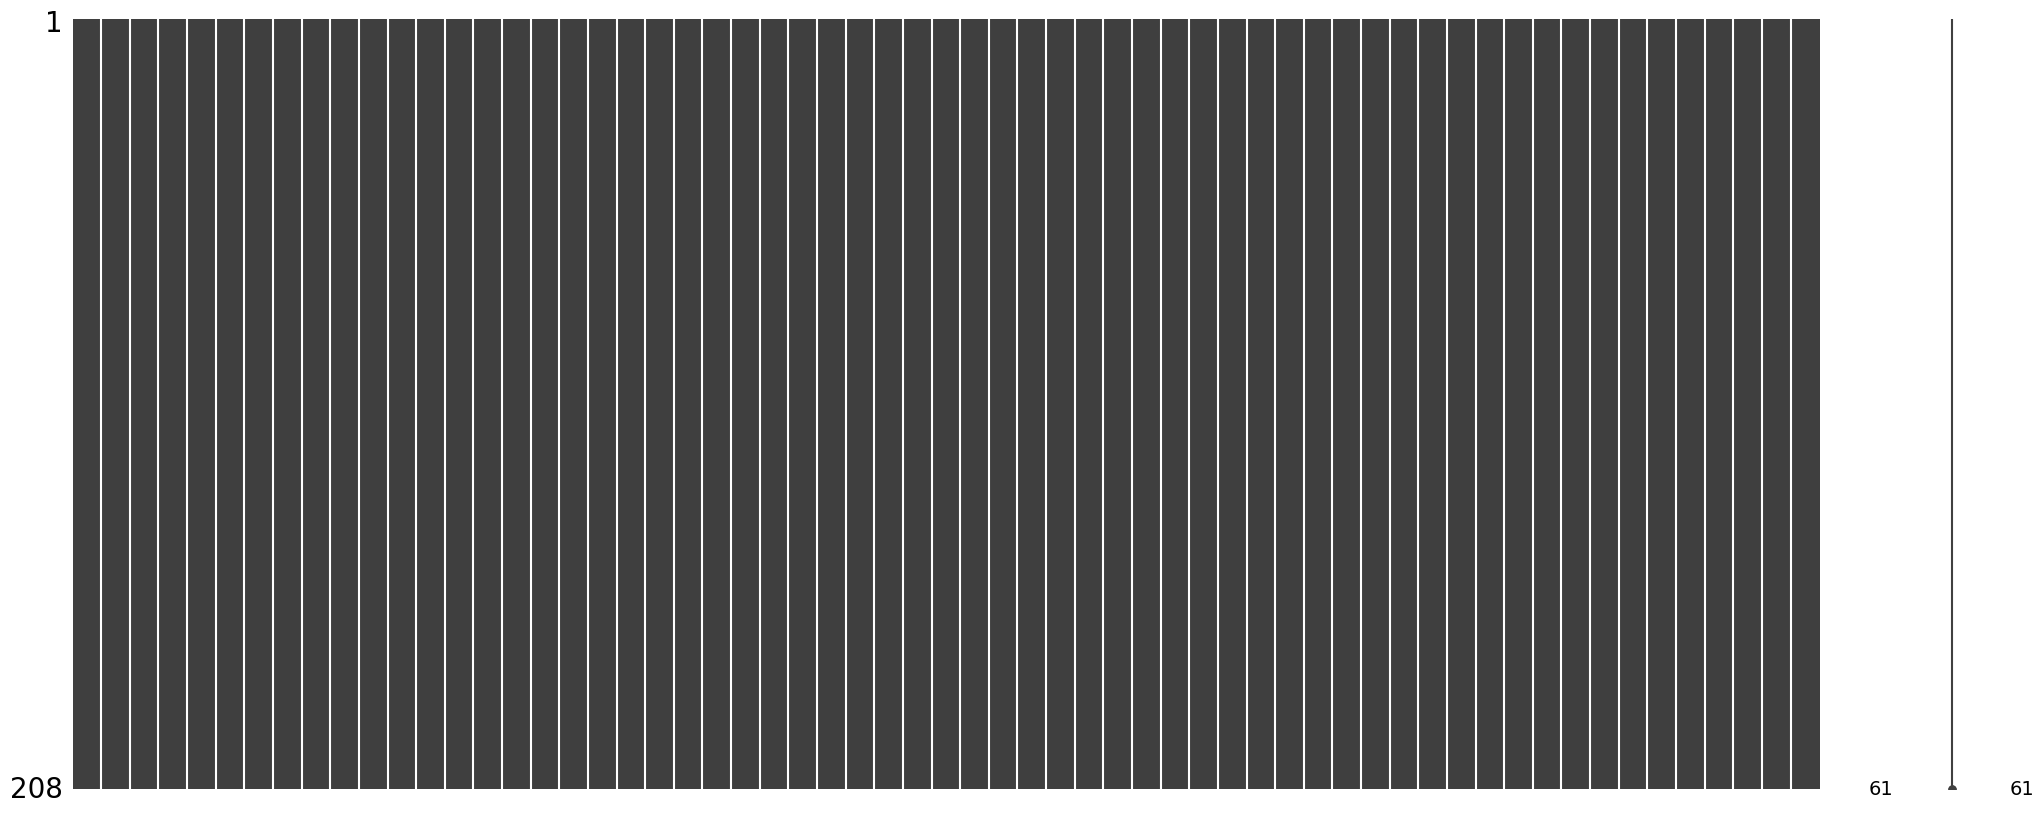

In [8]:
msno.matrix(df)

- **결측치가 있으면**
- 흰색이 그어져있다~
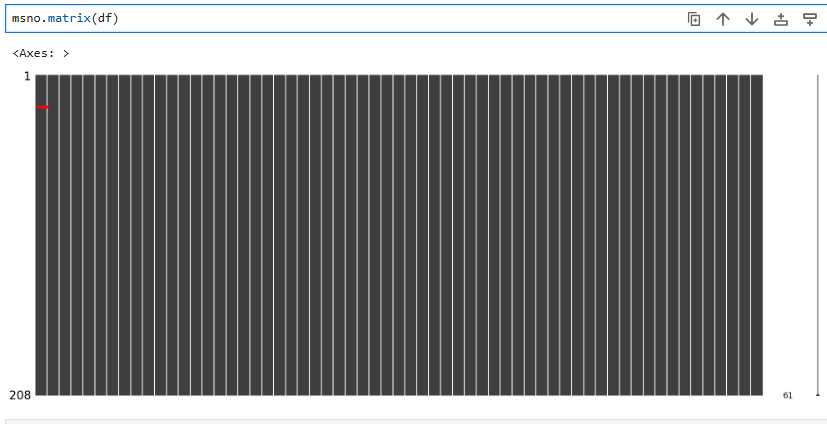

In [9]:
df[60].value_counts()

60
M    111
R     97
Name: count, dtype: int64

In [10]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

# ver1(원핫인코딩 방식)

In [11]:
enc_y = pd.get_dummies(y, dtype = int)

In [12]:
enc_y.head()

,M,R
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [13]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    enc_y, 
    test_size =0.2,
    stratify = enc_y,
    random_state = 34
)

In [14]:
x_sub, x_val, y_sub, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size = 0.2,
    stratify = y_train, 
    random_state = 34
)

In [15]:
x_sub.shape, x_val.shape, x_test.shape

((132, 60), (34, 60), (42, 60))

In [17]:
# 스케일링
mm = MinMaxScaler()
scaled_sub = mm.fit_transform(x_sub)
scaled_val = mm.transform(x_val)
scaled_test = mm.transform(x_test)

In [18]:
# 모델링
model = keras.Sequential()
model.add(keras.Input(shape = (60,))) # 입력층
model.add(keras.layers.Dense(64, activation = "relu")) # 은닉층 : 이건 그냥 강사님마음
model.add(keras.layers.Dense(32, activation = "relu")) # 은닉충 : 요약해주는 절차
model.add(keras.layers.Dense(2, activation = "softmax")) # 출력층

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,050 (23.63 KB)

 Trainable params: 6,050 (23.63 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

In [24]:
es_cd = keras.callbacks.EarlyStopping(patience = 8, restore_best_weights = True)

In [25]:
history = model.fit(scaled_sub, y_sub, epochs=200, batch_size=32, validation_data=(scaled_val, y_val), callbacks=[es_cd])

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4621 - loss: 0.7367 - val_accuracy: 0.8235 - val_loss: 0.6319
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6970 - loss: 0.6532 - val_accuracy: 0.6765 - val_loss: 0.6167
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6742 - loss: 0.6275 - val_accuracy: 0.6176 - val_loss: 0.6087
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6591 - loss: 0.6112 - val_accuracy: 0.6471 - val_loss: 0.5951
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6742 - loss: 0.5930 - val_accuracy: 0.7059 - val_loss: 0.5780
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7424 - loss: 0.5731 - val_accuracy: 0.7647 - val_loss: 0.5545
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7803 - loss: 0.5561 - val_accuracy: 0.7941 - val_loss: 0.5385
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7424 - loss: 0.5441 - val_accuracy: 0.8235 - val_loss:

In [26]:
model.evaluate(scaled_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6905 - loss: 0.5783


[0.5782570242881775, 0.6904761791229248]

In [27]:
y_test.head()

,M,R
87,0,1
19,0,1
68,0,1
95,0,1
35,0,1


In [28]:
model.predict(scaled_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[0.3661146 , 0.63388544],
       [0.957955  , 0.04204502],
       [0.29127318, 0.7087268 ],
       [0.06454972, 0.93545026],
       [0.84989643, 0.15010352]], dtype=float32)

# ver2(LabelEncoder) : 0과 1로 종속변수를 변경

In [32]:
le = LabelEncoder()
y = le.fit_transform(y)

In [33]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size= 0.2, 
    stratify= y,
    random_state= 34
)

In [35]:
x_sub, x_val, y_sub, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size = 0.2,
    stratify = y_train, 
    random_state = 34
)

In [36]:
mm = MinMaxScaler()
scaled_sub = mm.fit_transform(x_sub)
scaled_val = mm.transform(x_val)
scaled_test = mm.transform(x_test)

In [39]:
# 모델링
model2 = keras.Sequential()
model2.add(keras.Input(shape = (60,))) # 입력층
model2.add(keras.layers.Dense(64, activation = "relu")) # 은닉층 
model2.add(keras.layers.Dense(32, activation = "relu")) # 
model2.add(keras.layers.Dense(1, activation = "sigmoid")) # 출력층 ( 0 ~ 1 사이값 )

In [40]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model2.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [42]:
es_cb = keras.callbacks.EarlyStopping(
    patience=8,
    restore_best_weights= True
)

In [43]:
history2 = model2.fit(
    scaled_sub,
    y_sub,
    epochs=200,
    batch_size=32,
    validation_data=(scaled_val, y_val),
    callbacks=[es_cb]
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4773 - loss: 0.7241 - val_accuracy: 0.4706 - val_loss: 0.6980
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6667 - loss: 0.6704 - val_accuracy: 0.5294 - val_loss: 0.6786
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6212 - loss: 0.6564 - val_accuracy: 0.5588 - val_loss: 0.6687
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6212 - loss: 0.6463 - val_accuracy: 0.5588 - val_loss: 0.6566
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6364 - loss: 0.6333 - val_accuracy: 0.5588 - val_loss: 0.6441
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6288 - loss: 0.6289 - val_accuracy: 0.5882 - val_loss: 0.6436
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6439 - loss: 0.6143 - val_accuracy: 0.5588 - val_loss: 0.6316
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6970 - loss: 0.5992 - val_accuracy: 0.6176 - val_loss:

In [44]:
model2.evaluate(scaled_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8810 - loss: 0.3448


[0.34478670358657837, 0.8809523582458496]

In [45]:
y_test[:5]

array([0, 0, 0, 0, 0])

In [46]:
model2.predict(scaled_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[0.00559388],
       [0.09437172],
       [0.88351315],
       [0.2785909 ],
       [0.10556541]], dtype=float32)